In [1]:
%reload_kedro

2023-05-03 18:16:05,211 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/gpalazzo/Desktop/dev/crypto_msc_thesis
2023-05-03 18:16:05,738 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2023-05-03 18:16:05,881 - kedro.extras.extensions.ipython - INFO - ** Kedro project crypto_thesis
2023-05-03 18:16:05,882 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import quantstats as qs
import math
import seaborn as sns

In [4]:
portfolio_initial_money = catalog.load("params:portfolio_initial_money")

2023-05-03 18:16:06,930 - kedro.io.data_catalog - INFO - Loading data from `params:portfolio_initial_money` (MemoryDataSet)...


## Buy and Hold

In [5]:
df_benchm_buyhold = catalog.load("benchmark_buyhold_strat")

2023-05-03 18:16:06,934 - kedro.io.data_catalog - INFO - Loading data from `benchmark_buyhold_strat` (ParquetDataSet)...


In [6]:
first_time = df_benchm_buyhold.date.min()
last_time = df_benchm_buyhold.date.max()

first_price = float(df_benchm_buyhold[df_benchm_buyhold["date"] == first_time]["close_px"])
last_price = float(df_benchm_buyhold[df_benchm_buyhold["date"] == last_time]["close_px"])

In [7]:
# retorno percentual
pctchg = last_price / first_price - 1

# profit nominal
qty = math.floor(portfolio_initial_money / first_price)
profit_nominal = qty * last_price - portfolio_initial_money

# sharpe
vol = np.nanstd(df_benchm_buyhold["pctchg"], ddof=1)
sharpe = pctchg / vol

In [8]:
print(f"Cumulative return: {pctchg*100}%")
print(f"Nominal profit: {profit_nominal}")
print(f"Sharpe: {sharpe}")

Cumulative return: 208.60814237114064%
Nominal profit: 311549.4
Sharpe: 506.27275375812945


## Trend Following

### Operations Profit over Time

In [9]:
df_portf_pnl = catalog.load("benchmark_trendfollowing_pnl")

2023-05-03 18:16:07,119 - kedro.io.data_catalog - INFO - Loading data from `benchmark_trendfollowing_pnl` (ParquetDataSet)...


In [10]:
df_ops = df_portf_pnl[["close_time", "op_full_profit"]] \
                .sort_values(by="close_time", ascending=True) \
                .reset_index(drop=True)

accum_mean = []
accum_std = []

for i in range(len(df_ops.index)):
    _accum_mean = df_ops.iloc[0:i+1].op_full_profit.mean()
    _accum_std = df_ops.iloc[0:i+1].op_full_profit.std(ddof=1)
    
    accum_mean.append(_accum_mean)
    accum_std.append(_accum_std)
    
# accum_std[0] = 0.0 #first data point has std as NaN, so substitute by 0

df_ops.loc[:, "mean"] = accum_mean
df_ops.loc[:, "std"] = accum_std

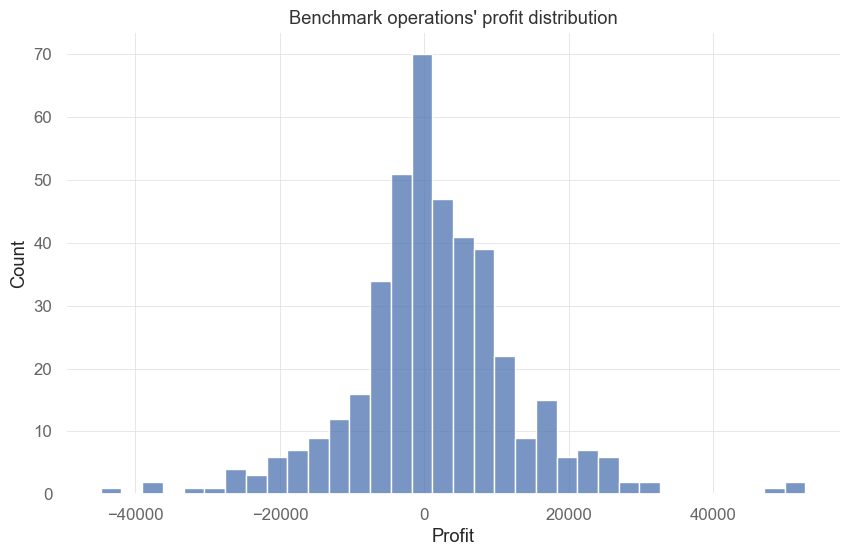

In [20]:
df = df_ops[["close_time", "op_full_profit"]] \
            .rename(columns={"close_time": "Date",
                            "op_full_profit": "Profit"}) \
            .set_index("Date") \
            .sort_index()

plot = sns.histplot(data=df,
             legend=None,
             x="Profit",
            ) \
            .set(title="Benchmark operations' profit distribution")

plt.savefig("/Users/gpalazzo/Desktop/fig_benchm_tf_ops_profit.png")

<Axes: title={'center': "Operations' Profit std over time"}, xlabel='Date', ylabel='Profit Std'>

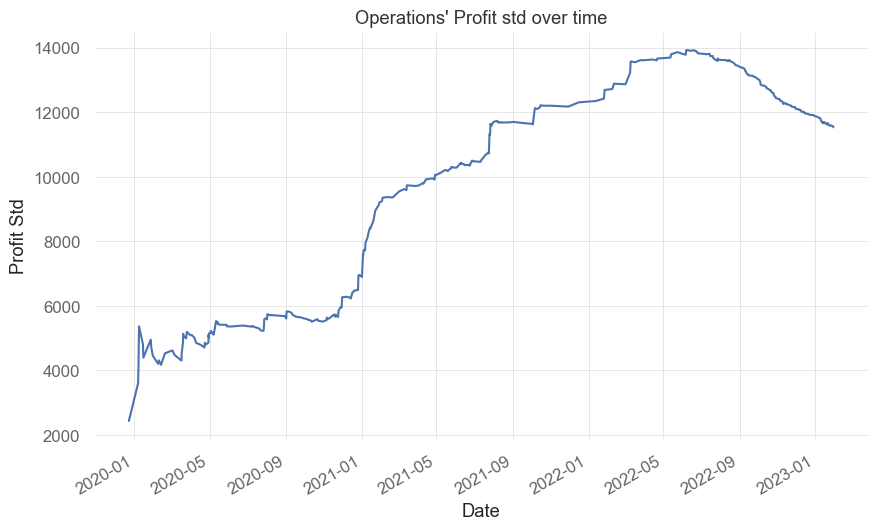

In [12]:
df_ops[["close_time", "std"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit std over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Std"
                    )

<Axes: title={'center': "Operations' Profit mean over time"}, xlabel='Date', ylabel='Profit Mean'>

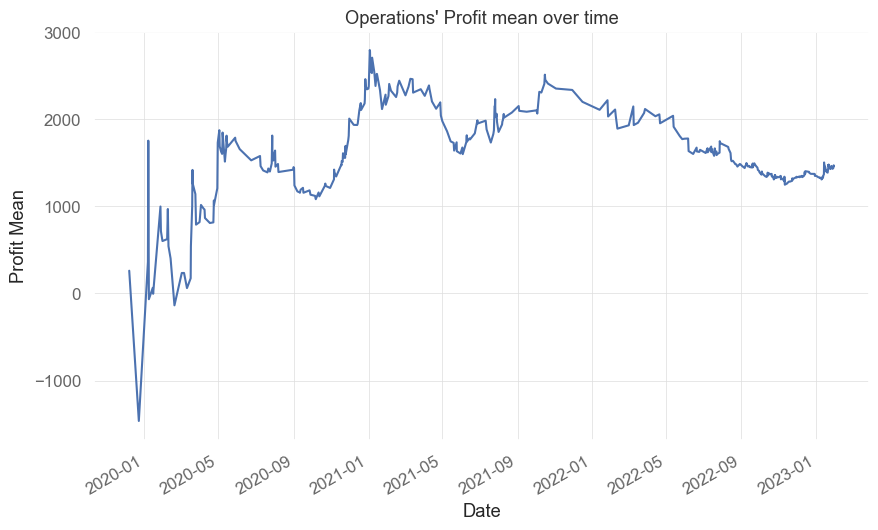

In [13]:
df_ops[["close_time", "mean"]].set_index("close_time").sort_index(). \
                plot(title="Operations' Profit mean over time", 
                     legend=None,
                     xlabel="Date",
                     ylabel="Profit Mean"
                    )

### Portfolio overall metrics - Part 1

In [21]:
df_portf_metr = catalog.load("benchmark_trendfollowing_metrics")
df_portf_metr.loc[:, "model"] = "benchmark_tf"
df_portf_metr

2023-05-03 18:18:37,818 - kedro.io.data_catalog - INFO - Loading data from `benchmark_trendfollowing_metrics` (ParquetDataSet)...


,nominal_profit,consecutive_wins,consecutive_losses,model
0,607541.887435,6,8,benchmark_tf


### Portfolio overall metrics - Part 2

In [22]:
df_portf_pnl = catalog.load("benchmark_trendfollowing_pnl")

df_portf_pnl.loc[:, "logret_pos"] = np.log(1 + df_portf_pnl["pctchg_pos"])

df_logret = df_portf_pnl[["close_time", "pctchg_pos", "logret_pos"]] \
                        .rename(columns={"close_time": "date"}) \
                        .set_index("date").sort_index()

df_logret.loc[:, "logret_accum"] = df_logret["logret_pos"].cumsum()
df_logret.loc[:, "pctchg_accum"] = np.exp(df_logret["logret_accum"]) - 1

df_logret = df_logret[["pctchg_pos", "pctchg_accum"]] \
                    .rename(columns={"pctchg_pos": "portf_pctchg_pos",
                                   "pctchg_accum": "portf_pctchg_accum"})

df_logret.index = pd.to_datetime(df_logret.index)

2023-05-03 18:18:39,465 - kedro.io.data_catalog - INFO - Loading data from `benchmark_trendfollowing_pnl` (ParquetDataSet)...


In [16]:
qs.reports.metrics(returns=df_logret["portf_pctchg_pos"], periods_per_year=360)

                    Strategy
------------------  ----------
Start Period        2019-12-07
End Period          2023-01-29
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   405.03%
CAGR﹪              67.27%

Sharpe              3.17
Prob. Sharpe Ratio  99.98%
Sortino             5.38
Sortino/√2          3.81
Omega               1.59

Max Drawdown        -21.36%
Longest DD Days     453

Gain/Pain Ratio     0.72
Gain/Pain (1M)      2.56

Payoff Ratio        1.27
Profit Factor       1.59
Common Sense Ratio  2.0
CPC Index           1.13
Tail Ratio          1.25
Outlier Win Ratio   3.52
Outlier Loss Ratio  3.54

MTD                 16.22%
3M                  28.96%
6M                  26.98%
YTD                 16.22%
1Y                  29.63%
3Y (ann.)           75.2%
5Y (ann.)           67.27%
10Y (ann.)          67.27%
All-time (ann.)     67.27%

Avg. Drawdown       -5.0%
Avg. Drawdown Days  38
Recovery Factor     18.96
Ulcer Index         0.09
Serenity Index      